# Cliff Walking 问题描述

This gridworld example compares Sarsa and Qlearning, highlighting the difference between on-policy (Sarsa) and off-policy (Qlearning) methods. Consider the gridworld shown in the figure below. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start.

![CliffWalking](./Cliff_walking.png)

In this file, I will compare Sarsa and Q-learning

# 代码部分

首先建立环境函数envir，函数的输入是当前位置(x,y)和动作a，输出是下一刻位置(x,y)和奖励r

In [1]:
x_length = 12
y_length = 4

def envir(x, y, a):
    at_goal = 0      # 此变量为0表示不在终点，为1表示在终点
    if x == x_length-1 and y==0:
        at_goal = 1
    
    # 四个移动方向
    if a == 0:
        y += 1
    if a == 1:
        x += 1
    if a == 2:
        y -= 1
    if a == 3:
        x -= 1
        
    x = max(0, x)
    x = min(x_length-1, x)
    y = max(0, y)
    y = min(y_length-1, y)
    
    if at_goal == 1:     # 虽然在终点，但为更新Q函数，还是要返回奖励-1
        return x, y, -1
    if x>0 and x<x_length-1 and y==0:
        return 0, 0, -100
    return x, y, -1

下面定义$\epsilon$-贪心策略，参数Q是指Q函数（类型为numpy.ndarray）。函数epsilon_greedy_action返回$\epsilon$-贪心策略下的动作；函数optimal_action返回当前最佳动作。

In [2]:
import random
import numpy as np
epsilon = 0.1

def epsilon_greedy_action(x, y, Q, eps=epsilon):
    t = random.randint(0, 3)
    if random.random()<eps:
        a = t
    else:
        a = optimal_action(x, y, Q)
    return a

def optimal_action(x, y, Q):
    return np.argmax(Q[x, y])

下面这个函数用来根据Q函数画出路径

In [3]:
def drawPath(Q):
    for y in range(y_length)[::-1]:
        for x in range(x_length):
            a = np.argmax(Q[x,y])
            if a == 0:
                print("↑", end="")
            elif a == 1:
                print("→",end="")
            elif a == 2:
                print("↓",end="")
            elif a == 3:
                print("←",end="")
            else:
                print("0",end = "")
        print("")

## Sarsa 算法

![Sarsa](./SARSA_algo.png)

In [4]:
# Sarsa on-policy
alpha = 0.5
gamma = 1

def sarsa_on_policy(Q):
    episodes = 100
    rewards = []
    
    for i in range(episodes):
        reward_sum = 0
        x, y = 0, 0                        # initialize S
        a = epsilon_greedy_action(x, y, Q) # choose a
        
        while True:                        # for each step of episode
            x_next, y_next, reward = envir(x, y, a)
            reward_sum += reward
            a_next = epsilon_greedy_action(x_next, y_next, Q)
            Q[x,y,a] += alpha * (reward + gamma*Q[x_next, y_next, a_next] - Q[x,y,a])
            if x == x_length-1 and y==0:
                break
            x, y, a = x_next, y_next, a_next
            
        rewards.append(reward_sum)
    
    return Q, rewards

In [5]:
Q = np.zeros([12,4,4])
Q_opt, rewards = sarsa_on_policy(Q)

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(rewards)), rewards)
plt.show()

<Figure size 640x480 with 1 Axes>

下面画出路径，最左下角的点是起始点，最右下角的点是终点

In [7]:
drawPath(Q_opt)

→→→↓→←↑→→→→↓
↑↓→→→↑→↑→↑→↓
↑↑↑↑↑↑←↑←↑→↓
↑↑↑↑↑↑↑↑↑↑↑←


## Q-learning 算法

![Q-learning](./Q_learning_algo.png)

In [8]:
# Q-learning off-policy
alpha = 0.5
gamma = 1

def q_learning_off_policy(Q):
    episodes = 100
    rewards = []
    
    for i in range(episodes):
        reward_sum = 0
        x, y = 0, 0                        # initialize S
        
        while True:                        # for each step of episode
            a = epsilon_greedy_action(x, y, Q) # choose a
            x_next, y_next, reward = envir(x, y, a)
            reward_sum += reward
            a_next = optimal_action(x_next, y_next, Q)
            Q[x,y,a] += alpha * (reward + gamma*Q[x_next, y_next, a_next] - Q[x,y,a])
            if x == x_length-1 and y==0:
                break
            x, y = x_next, y_next
            
        rewards.append(reward_sum)
    
    return Q, rewards

In [9]:
Q = np.zeros([12,4,4])
Q_opt, rewards = q_learning_off_policy(Q)

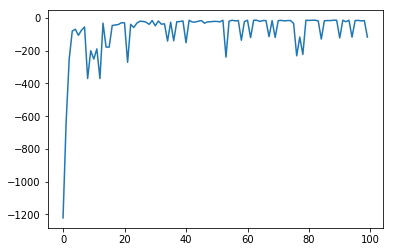

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(len(rewards)), rewards)
plt.show()

In [11]:
drawPath(Q_opt)

→→↑→→→→→→↓→↓
→↓→→↓→↓→→→→↓
→→→→→→→→→→→↓
↑↑↑↑↑↑↑↑↑↑↑←


从这两幅图中可以看出，Q-learning在更新Q函数时每次选择最优的动作，所以效果更aggressive，相比之下，Sarsa的效果更conservative。